                                             Workshop 5: Dragos Gruia and Valentina Giunchiglia

# Graph theory analysis: probing the normal and abnormal connectome

In this workshop, we are going to use graph theory and represent functional MRI data as a connected graph. The nodes in our graph will correspond to regions of interest (ROI) in the brain, and the edges between nodes will be based on a measure of functional connectivity between each pair of regions. The purpose of building the graph is to be able to come up with concise and powerful descriptions of the complex organisation of the brain. 

### Graphs and regions of interest (ROIs)

There are typically 1000s or 100,000s of voxels in a brain scan. Depending on the research hypothesis, we may want to reduce this down to something more manageable. Especially if we are running connectivity analyses in a pairwise manner because the number of connections increases exponentially with the number of nodes. Typically, we choose a smaller number of **regions of interest (ROI)** and just focus on these to make the analysis tractable. As we will see, these ROIs will be the starting point for defining a graph, composed of **nodes** (e.g. the ROI) and their **edges** (e.g. the functional connectivity between nodes). You should have learnt in Day4 what functional connectivity is, but in summary it corresponds to the statistical dependence between the timeseries of two voxels in the brain. Graph theory has many metrics that are useful for describing/summarising the functional connectivity of the brain as a whole, and in this workshop we will learn some of the most important ones.

### Examples of a graph

Here's some examples of the brain as a graph or network. Figure from Taken from Vertes et al, 2013, Phil Trans Royal Society B) 

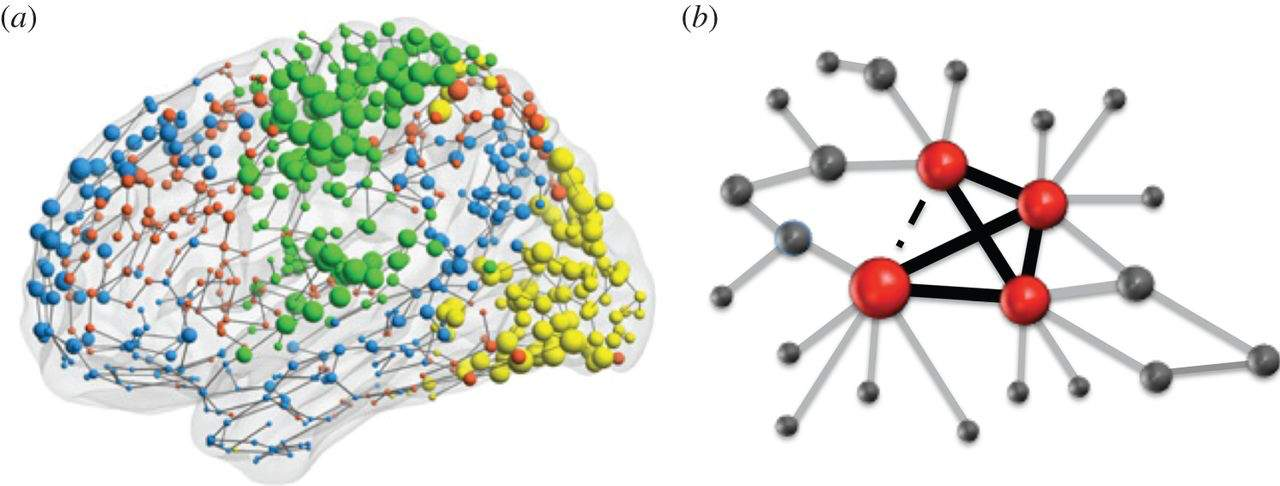

A ROI (which corresponds to the nodes in the graph) can be defined in lots of different ways, again depending on the research question. In order to define ROIs, we can use different brain parcellations. Parcellation consists of defining distinct partitions in the brain, where each one of them corresponds to areas or networks that comprise different but closely interacting regions. Parcellations can have different levels of granularity, meaning that the brain can be divided into smaller or bigger regions. Which parcellation to use really depends on the research questions. The following picture just provides an example of how the brain can be divided into smaller/bigger regions - each color correspond to a different brain region according to five distinct parcellations.

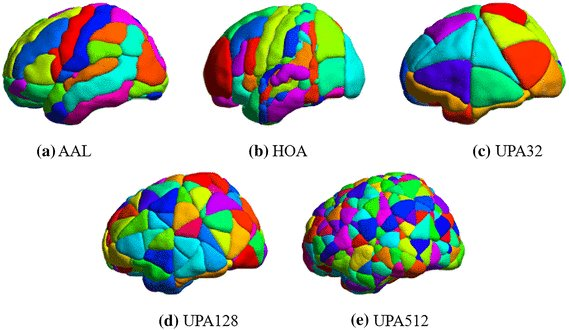

Information about the location of each brain region according to the brain parcellations is usually provided within **brain atlases**, that essentially  define the shape and location of brain regions in a common coordinate space (that corresponds to the standard brain template that we used in day4). 

### A parcellation of the brain

In this workshop, we will use a recent parcellation that combined many different imaging modalities to define ROIs (180 in total) that cover the entire brain, whose location and shape is defined within the **Glasser Atlas**. A summary of the brain parcellation used is available in the following figure (Taken from [here](https://www.nature.com/articles/nature18933)). 

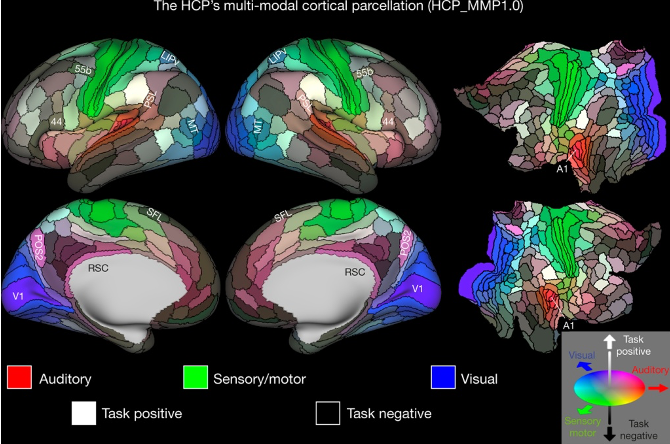

### Workshop outline
In the workshop of today, we will complete the following steps:
* **Step 1**: Load some resting-state fMRI data 
* **Step 2**: extract some ROI timecourses for each of our ROIs
* **Step 3**: Build a graph from these ROI timecourses
* **Step 4**: Calculate some graph theory metrics
* **Step 5**: Do some exercises along similar lines but comparing two conditions - placebo and the psychedelic state with LSD

## Step 1 
### Load resting-state fMRI data and an atlas

We shall do some analysis on resting-state fMRI data for a single subject. If you remember from Day4, resting-state data lack an explicit task: the subject is asked to lie in the scanner and not think about anything in particular (if that's possible). 

In order to be able to run this tutorial, you need to download the Day5 data and save them in the directory called *Data*. The data that we will use today are the following: 
1. *fmri.nii.gz*: is a 4D file containing the cleaned resting state fMRI for a single subject.
2. *atlas.nii.gz*: is a 3D file that contains information about the Glasser atlas, and namely the parcellation displayed above, whereby each location in the brain is assigned a number, corresponding to the ROI which that voxel belongs to. If you remember, in Day4 we used something similar, namely a *mask* for a specific ROI. In this case, instead, we have masks for all 180 ROIs. 


Let's start to import all the modules we will need in the workshop.

In [121]:
import nibabel as nib
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import seaborn as sb
import pandas as pd
%matplotlib inline
import numpy as np
import os
import warnings
import copy

warnings.filterwarnings('ignore')

sb.set_theme("talk")
sb.set_style("whitegrid")

Now we can load the *fmri* data and the *atlas* in the same way we learnt in Day4. Let's checl their shapes.

In [4]:
fmri = nib.load("Data/fmri.nii.gz")
atlas = nib.load("Data/atlas.nii.gz")

fmri_arr = np.array(fmri.dataobj)
atlas_arr = np.array(atlas.dataobj)

fmri_arr.shape, atlas_arr.shape

((91, 109, 91, 217), (91, 109, 91))

As expected, the fMRI has 4 dimensions (x, y, z and time). What about the atlas?

### Visualise the atlas

Let's check out a 2D slice of the atlas, to see what it looks like in one plane

(-0.5, 108.5, 90.5, -0.5)

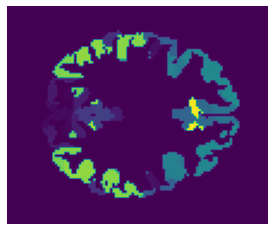

In [12]:
plt.imshow(atlas_arr[:, :, 50], cmap = "viridis")
plt.axis("off")

    Do you understand what the meaning of the [:,:,50] in this example is? Try to change the number and then the order of those arguments. What happens? If you are not sure, you should check out the Day4 material. 
    
To better understand - let's visualise the same brain slice using the fMRI data. 

(-0.5, 108.5, 90.5, -0.5)

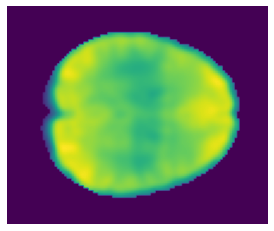

In [13]:
plt.imshow(fmri_arr[:, :, 50,123], cmap = "viridis")
plt.axis("off")

    What is the meaning of the 123 in this example?

After plotting the atlas, you should notice two main things. First of all, most of the brain is empty. The reason is that the parcellation we are using corresponds to a type of **cortical parcellation**, which means that it is concerned only with the human cortex and it ignores a lot of the brain in volumetric terms (i.e. the white matter).


Then, you should realise that different regions of the brain have different colours. In atlases, each unique colour represents a unique integer identifier for a ROI. Since in the whole atlas there are 180 ROIs, in total there are 180 unique identifiers (or colours). You don't need to worry too much about which colours are used (although you could easily change the colormap in Python). What is important to appreciate is that if you want to use the atlas properly, you need to know: 1) the range of numbers that is in the atlas, and 2) which numbers correspond to the regions of interest that you want to study/analyse. These numbers can then be used to to extract the timecourse of the fMRI voxels that are at the same location as the ROI (that sit "underneath" that region of the atlas image). 

Some atlases are labelled from 0 upwards, or 1 upwards; others have less obvious numbering that might start labelling regions from any old number. They might not even be contiguously numbered (i.e. it might be 1,2,50,51,100, rather than 1..180 straight).

Fortunately this atlas treats "nothing" as 0, and then the numbers 1..180 represent our 180 ROIs.

If you want to extract the *mask* of one ROI (similar to the mask we used in Day4), you just have to extract the regions in the atlas that are equal to the ID number associated to the region of the brain that you want to study. We will look at this in details throughout the workshop.



## Step 2 - Extracting the timecourses

Let's try to extract the average timecourse from all of the voxels in each ROI. There are lots of ways to do this. The easiest way is to use the same approach that we used in day4, but this time, we will implement a ready to use function, in order to avoid having to copy and paste the code multiple times. In summary our function will:
1. Take as input the fMRI data and a binary mask that specifies which ROI we are extracting
2. Loop over all the voxels in the brain and extract the timecourse of the voxels located only where the mask is == 1 (that corresponds to the ROI)
3. Calculate and return the mean timecourse across all voxels in the ROI. To do this, we are going to use the *nanmean* function in Python to find the average timecourse value across all the voxels in the ROI (nanmean calculates a mean but will not break if there are NaN values, which mean Not a Number. In this case we aren't expecting any NaNs anyway, but it is better to use it as prevention)

In [33]:
def extract_timecourse(fmri,mask):
    timecourse = []
    for x in range(fmri.shape[0]):
        for y in range(fmri.shape[1]):
            for z in range(fmri.shape[2]):
                if mask[x, y, z] == 1:
                    timecourse.append(fmri[x,y,z,:])
    
    timecourse = np.nanmean(timecourse, axis=0)
    return np.array(timecourse)              
                    

As you can see from the function, one of the inputs is a binary mask. How do we obtain that? Let's say that we want to extract the mean timecourse of the voxels in ROI number 11. Then we have to take the atlas and set as 1 only the regions where the ID number is equal to 11. To do that, we can easily check where the atlas is equal to 11, and then convert the output (which is a boolean) to integer. In boolean arrays, True corresponds to 1 and False to 0, when turned to integer.

In [34]:
mask = (atlas_arr == 11).astype(int)

Let's try out the function!

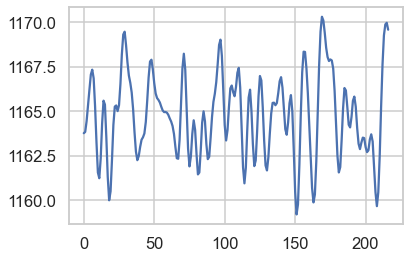

In [36]:
tc = extract_timecourse(fmri_arr, mask)
plt.plot(tc)

    Do you understand what the plot is showing you? What is the y coordinate here? What is the 'x' coordinate?

Try changing the 11 above to a different ROI identifier, and see if your timecourse changes! For example, what happens tcif you specify 181?

------
### Code here

On its own a single timecourse is relatively uninteresting. What we want is to calculate timecourses for each of the ROIs. To do this we can use a for loop with our new function to extract all of the timecourses for ROI IDs 1..180. We simply need to make a for loop and iterate over each ROI identifier (from 1 to 180), being sure to store the results somewhere.

**HINT** you should store the timecourses in a variable called *All_ROI_Timecourses* that you should initialise as all 0 - which shape should it have? Check the shape of *tc* if you are not sure.


In [43]:
# Code here

-----

## Step 3 - Building a graph from the timecourses

Remember a graph is made up of nodes and edges between them.

In our case, we will have one node for each ROI (i.e. 180 nodes).

How do we calculate edges between nodes? For any graph, we need to decide whether there is an edge (binary yes/no) between any given pair of nodes, and also (in some graphs, called **weighted graphs**), we ascribe each edge a value, or weight. 

To calculate our edges between ROIs, we will calculate the *functional connectivity* between pairs of nodes. If there is functional connection between them, then there is an edge (binary graph). We can also create a version of the graph where the weight of each edge corresponds to the *strength* of the functional connectivity (the correlation value).

Note that there are 101 ways to define functional connectivity, and lots of methodological considerations about the appropriate ways to do this. For our purposes here we are going to use a simple correlation. We can do this using the Python function corrcoef like we did in Day 4. The difference is that we want to calculate the correlation between the average timecourses of each pair of nodes, rather than comparing the timecourse of every voxel to a "seed". To do this, we need two for loops. The first for loop iterates over all the average timecourses of the 180 regions of interests, and the second for loop does exactly the same thing. In this way it is possible to calculate all the possible pairwise correlations between each ROIs. The results are stored in a variable called `pairwise_FC`.

In [47]:
pairwise_FC = np.zeros((All_ROI_Timecourses.shape[1],All_ROI_Timecourses.shape[1]))
for i in range (0,All_ROI_Timecourses.shape[1]):
    for j in range(0,All_ROI_Timecourses.shape[1]):
        pairwise_FC[i,j]=np.corrcoef(All_ROI_Timecourses[:,i], All_ROI_Timecourses[:,j])[0][1]

The resulting connectivity values are the edges of our graph. To get a good overview of the data we can look at this connectivity matrix using a `heatmap`.

Text(0.5, 1.0, 'Functional connectivity')

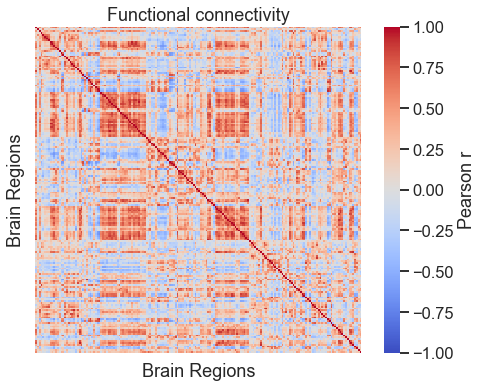

In [48]:
# Visualise FC for the first subject
f = plt.figure(figsize=(8, 6))
hm = sb.heatmap(pairwise_FC,
                xticklabels=False,
                yticklabels=False,
                cmap='coolwarm',
                cbar_kws={'label': 'Pearson r'},
                # the matrix contains NaN values on the diagonal - this line and
                # the next excludes those from the colormap
                vmin=-np.nanmax(abs(pairwise_FC.flatten())),  
                vmax=np.nanmax(abs(pairwise_FC.flatten())))   

hm.set_aspect('equal')                # make the heatmap plot square
plt.xlabel('Brain Regions', labelpad=10)
plt.ylabel('Brain Regions', labelpad=10)
plt.title('Functional connectivity')

This matrix corresponds to a simplified and flattened version of our graph (we just haven't drawn it as circles - e.g nodes - and lines e.g. edges - between them). There are other functions and programs for plotting graphs, and tools for plotting graphs on brains, which you can try and explore if you have time.

In the current graph, every pair of nodes is connected by a an edge, which is represented by a weight (the R value from our correlation). Often, however, we want to restrict the number of edges of the graph because:
1. We don't want connections that aren't really there influencing the results; and/or,
2. We may want to simplify the graph just to binary edges (there is an edge or there isn't).
One way to do this is based on whether the probability of the functional connectivity between nodes was significantly greater than chance, which is measured by the `p-value`.

To do this, let's first recalculate the pairwise functional connectivity, but keep the p-values as well as the correlation coefficients. The corrcoef function does not give us the p-values so instead we will use `pearsonr` function.

In [49]:
pairwise_FC = np.zeros((All_ROI_Timecourses.shape[1],All_ROI_Timecourses.shape[1]))
pairwise_pval = np.zeros((All_ROI_Timecourses.shape[1],All_ROI_Timecourses.shape[1]))
for i in range (0,All_ROI_Timecourses.shape[1]):
    for j in range(0,All_ROI_Timecourses.shape[1]):
        
        pairwise_FC[i,j], pairwise_pval[i,j] = stats.pearsonr(All_ROI_Timecourses[:,i],
                                                              All_ROI_Timecourses[:,j])


We can then use these p values to threshold the the `pairwise_FC matrix` (i.e. we set the value to 0 if the p value is over some threshold, otherwise we keep the weight value). This will result in a **weighted matrix/graph**. However, if we want to obtain a binary matrix, we can later on binarise the matrix by setting every non-zero value to 1. This will result in an **unweighted matrix/graph**. Let's change the function to account for the p-value and store the correlation result only if the p-value is below a chosen threshold.

In [50]:
threshold = 0.000001
pairwise_FC_Thresh = np.zeros(pairwise_FC.shape)
for i in range (0,180):
    for j in range(0,180):
            if pairwise_pval[i,j] < threshold:
                pairwise_FC_Thresh[i,j]= pairwise_FC[i,j]


-----
### Code here

Let's visualize the new results using a heatmap. Create a figure with **three** subplots where:
1. The first plot represents the heatmap of the FC matrix without filtering the weights according to the p-value
2. The second presents the FC matrix after filtering according to the p-values
3. The third plot represents a binary FC matrix, where all non-zero values are set equal to 1. Store the binary FC matrix in a variable called `Binary_Thresh_FC_Graph`

In [53]:
## Code here

------

    What is a sensible p-value threshold here? Try to modify the threshold and check how the results change

## Step 4 - Calculate simple graph metrics

The purpose of building the graph is to be able to come up with concise and powerful descriptions of the complex organisation of the brain. There are of course metrics that can be used to describe the characteristics of the obtained graph. More in detail, we can have **global measures** (covering the whole brain) and **local measures** (calculated for each node).

### Degree and strength
We'll start with some simple, local measures: **degree** and **strength**. Degree corresponds to the number of connections that a node has to other nodes (i.e., assuming the network is binary); strength, instead, is the sum of the weighted connections that each node has with other nodes (i.e. assuming the network is not binary). 

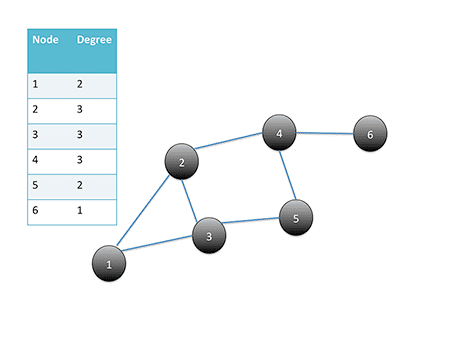

To calculate the degree of each node, we need to take the binary FC matrix, and get the sum along the axis 0 (i.e. the rows) which calculates the total number of edges that each node has.

In [66]:
Degree = np.sum(Binary_Thresh_FC_Graph, axis = 0)

To calculate the strength of each node, simply substitute the binary FC matrix with the weighted FC matrix pairwise_FC_Thresh

In [68]:
Strength = np.sum(pairwise_FC_Thresh, axis = 0)

These measures can tell us about:
1. how densely connected the graph is;
2. how evenly distributed the connections are.

They are of course just node measures, but they can be used to obtain more general measures about the entire graph, such as the **average degree**

In [69]:
np.mean(Degree)

52.922222222222224

Or the **density**, that corresponds to the the ratio between the edges present in a graph and the maximum number of edges that the graph can contain. To do this, we have to calculate the total number of connections, or edges, which corresponds to the sum of the degree, and divide the result by the number of all possible connections, or edges. The density can be calcualted as follows:

$$ \frac{2E}{N*(N-1)}$$

where *E* corresponds to the number of Edges and *N* to the number of nodes

In [84]:
E = np.sum(Degree)
N = Binary_Thresh_FC_Graph.shape[0]
Edges_graph = (2*E)
Total_connections = (N*(N-1))
Density= Edges_graph/Total_connections
Density

0.5913097454996896

These values are very abstract, and typically only become meaningful when compared to other graphs: for example, by comparing the graph with a random graph or by comparing graphs calculated from two different populations (e.g., healthy control and Alzheimer's disease). We will be able to make more interesting comparisons by comparing resting state to states where subjects had taken the psychedelic LSD. 

----
#### Code here

Let's try to compare the degree results to those of random values
1. Create random timecourses 
2. Calculate the Functional connectivity matrix
3. Measure the degree of each node
4. Create a figure with two suplots where the first plot consists of the actual node degrees and the second subplot corresponds to the node degrees of the random timecourses

**HINT**: To create random timecourses you can use the function *np.random.rand and provide as input the same shape of the actual timecourses. 

In [ ]:
## Code here

------

### Paths and distance

Calculating a node's degree and strength give a simple measure of how important different regions are; however, one big reason for studying the brain as a graph is to look at the paths that information can flow along over multiple nodes. A **path** is a route through the graph, and its length is the number of steps taken. In this example, there are several ways (or paths) to get from nodes 1 to 6. The red path from nodes 1 to 6 is the shortest possible path; and thinking about the shortest path is a useful way of thinking about how different nodes are connected to each other.

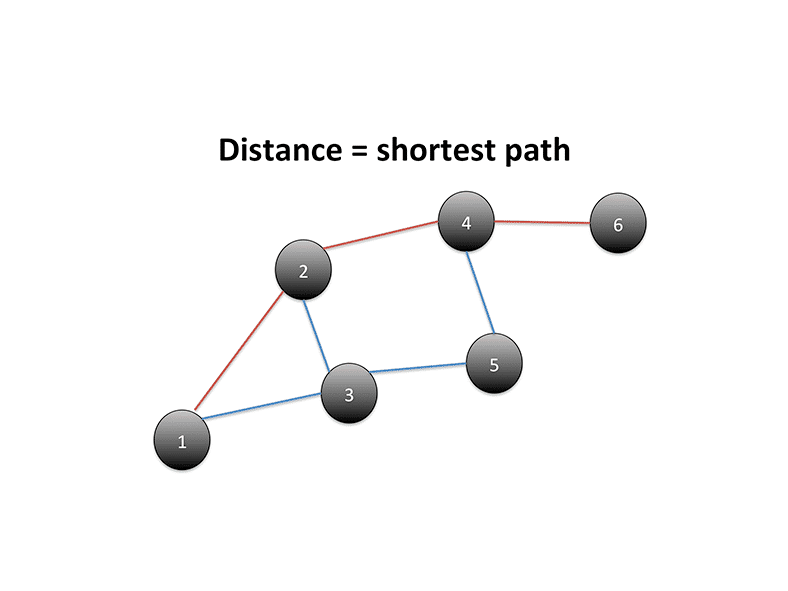

If we are interested in how *efficiently* the brain is connected, we are interested in the shortest path lengths between different nodes. We, therefore, want to calculate the distances (i.e., shortest paths length) between all the nodes in the graph. There's an illustration of the type of algorithm which you can see animated [here](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm#/media/File:DijkstraDemo.gif)

We are not going to implement this algorithm; instead, we will use the Brain Connectivity Toolbox (BCT). This is large set of functions for calculating graph metrics and related tools, written for Python.

Let's install it!

In [ ]:
pip install bctpy

In [92]:
import bct as bct

We can use the function `distance_bin` to calculate the shortest distances across the graph (distance is connections not actual physical Euclidean distance) between every pair of nodes. 

In [105]:
BinaryDistances = bct.distance_bin(Binary_Thresh_FC_Graph)

Let's visualise it using a heatmap

Text(0.5, 1.0, 'Distance graph')

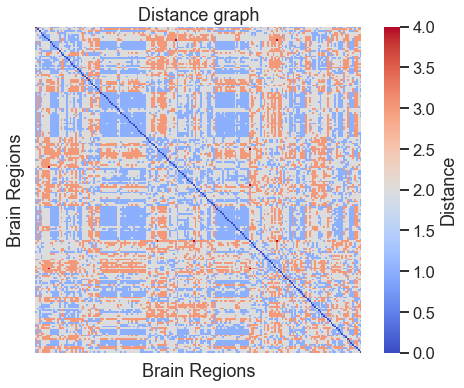

In [96]:
# Visualise FC for the first subject
f = plt.figure(figsize=(8, 6))
hm = sb.heatmap(BinaryDistances,
                xticklabels=False,
                yticklabels=False,
                cmap='coolwarm',
                cbar_kws={'label': 'Distance'},
                vmin=np.nanmin(abs(BinaryDistances.flatten())),  # the matrix contains NaN values on the diagonal - this line and the next excludes those from the colormap
                vmax=np.nanmax(abs(BinaryDistances.flatten())))   # (as above)

hm.set_aspect('equal')                # make the heatmap plot square
plt.xlabel('Brain Regions', labelpad=10)
plt.ylabel('Brain Regions', labelpad=10)
plt.title('Distance graph')

### Efficiency, hubs and other measures

A number of important graph statistics can be calculated based on the shortest path lengths. The **global efficiency** of the graph is the average of inverse shortest path length: if a graph has a short average path length then information can flow quickly from node to node, whereas if the average path length is large, more steps are necessary to move from node to node, on average. The local efficiency is the global efficiency computed on the neighborhood of the node (i.e. the inverse of the average path length for each node's neighbouring - connected - nodes).

The efficiency can be easily calculated in Python with the `efficiency_bin` function. If the second argument is 0, then the *global efficiency* is calculated, instead if it is 1, then the *local efficiency* is calculated.

In [116]:
GE=bct.efficiency_bin(Binary_Thresh_FC_Graph, 0)
GE

0.6105886612869852

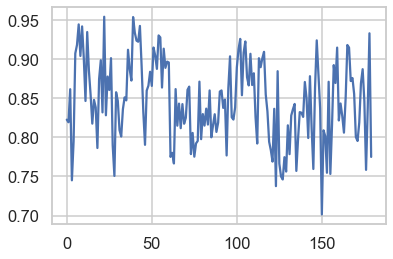

In [117]:
LE=bct.efficiency_bin(Binary_Thresh_FC_Graph, 1)
plt.plot(LE)

If we had two or more graphs, we could compare them and see which nodes have the same efficiency and which nodes have, instead, different ones.

Another important measure that relates to the shortest path length is the **betweeness centrality**. This is a quantitative measure of how **hub-like** a node is. The betweeness centrality is the proportion of shortest paths that pass through a node. If a node contains a large proportion of the shortest paths, then more communication across the network, on average, will pass through that node. Below is an illustration of betweeness centrality taken from Wikipedia, with nodes coloured by their betweeness centrality; nodes coloured in blue have higher betweeness centrality (and appear to be located towards the centre of the graph), instead nodes coloured in red have lower betweenes centrality. 

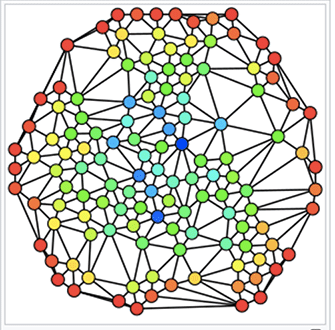

To calculate betweenness centrality in python, we can use the `betweenness_bin` command.  

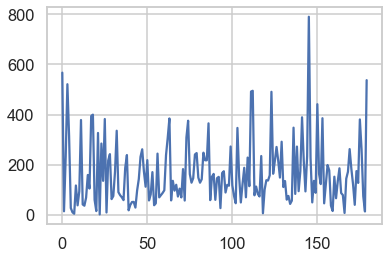

In [118]:
BC=bct.betweenness_bin(Binary_Thresh_FC_Graph)
plt.plot(BC)

You can easily find out, for instance, which ROI identifier has the highest value of betweenness centrality by using the `np.where()` function. This function takes as input a logical condition (e.g. values > 5) and it returns the index number of the values that meet the condition.

In [120]:
max_roi = np.where(BC == max(BC))
max_roi

(array([145]),)

This results in the betweenness centrality (hub-iness) of each node. You could investigate further to see which nodes are most hub-like or you could compare these values across different e.g., patient groups or experimental conditions. To find a ranking of the most **hub-like** nodes, you can sort the betweenness centrality (BC) values and also get the corresponding ROI indices quite simply. To do this, we create a dataframe with the BC values and the ROI index as two separate columns, then sort the rows of the dataframe based on the BC values. 

In [129]:
BC_df = pd.DataFrame({"BC":BC, "ROI_Index": range(1, 181)})
BC_df_sorted = BC_df.sort_values(by = "BC", ascending = False)
BC_df_sorted

BC  ROI_Index
145  790.209210        146
0    567.106105          1
179  537.166092        180
3    520.987050          4
112  494.756116        113
..          ...        ...
26     9.178017         27
166    7.312708        167
118    6.088470        119
7      4.230880          8
22     1.531803         23

[180 rows x 2 columns]

Let's print the 10 ROI, or nodes, with the highest BC values

In [133]:
BC_df_sorted.head(10)

BC  ROI_Index
145  790.209210        146
0    567.106105          1
179  537.166092        180
3    520.987050          4
112  494.756116        113
111  491.675603        112
123  490.747064        124
150  441.207013        151
18   399.528343         19
17   394.156988         18

At this point, however, you might rightly wonder, what is region X? In the files glasserrois.txt and glassertable.pdf in your data directory there is some information to answer this question.

The PDF comes from part of the (enormous) supplementary information from the original publication (see reference above, also glassersomesi.pdf for some of the full neuroanatomical supplementary information available that describes the regions in more detail).

The text file is a simple *look up table* that maps ROI integer id => ROI name, i.e. here's the first few lines:

* 1 -> L_V1_ROI 
* 2 -> L_MST_ROI 
* 3 -> L_V6_ROI

You could scroll through that file to look up the name of the ROI for a given integer identifier. But lets use the file in Python to do this for us, in a programmatic way. To do this we just need to load the text file in to Python and use the data in the right way.

There are at least 5 ways to load a text file like this in Python. Here we use read to load the data as a Python string, and then turn the string into a list by creating a separate element of the list for each row of the text file. 

In [164]:
with open('Data/glasserrois.txt') as f:
    roiInfo = f.read().split("\n")

The output is a list of strings, which is not super easy to manage. From that, we can create a dictionary, where the key is the ROI index number and the value is the name of the ROI. 

In [165]:
glasser_atlas = {}
for roi in roiInfo:
    if roi != "":
        index, name = roi.split(" ")
        glasser_atlas[int(index)] = name

Now you can easily look up what each ROI ID correspond to by extracting the value of the ID of interest from the dictionary. For example, if you want to extract the name of ROI ID 2, you would do:

In [166]:
roiInfo[2]

'3 L_V6_ROI'

-------
### Code here

1. Explore what effect the sparsity of the graph (i.e., the threshold level you set when binarising edges) has on the different graph metrics. 
2. Explore using weighted/unbinarised measures (e.g., using pairwise_FC_Thresh instead of Binary_Thresh_FC_Graph). 
3. Explore other graph measures from the BCT (ONLY if you have extra time)

In [167]:
# Code here

-----

# Challenge

The resting state data you analysed in the workshop was actually collected as part of the placebo condition of a study where the participants took the psychedelic drug LSD. The file fmrilsd.nii.gz contains imaging data for the LSD condition for the same subject (it was subject 12, S12, of the study). The aim of this challenge is to study the differences in the brain activation between control and LSD, by completing a subject level and group level analysis. We would like to understand what the effects of psychedelics on the brain are.

1. For the same subject, build a graph for the LSD condition (with the same ROIs) that you can compare to the placebo condition, and include figures as appropriate. Choose three graph metrics and calculate them for both placebo and LSD - what do you find? Is there any difference?
2. Carry out a group level analysis. We have made available two datasets, which contain data for subjects undergoing LSD and the same subjects undergoing placebo resting-state scans. The study was published in *Carhart-Harris, Robin L., et al. Neural correlates of the LSD experience revealed by multimodal neuroimaging. PNAS, 2016*. To help you, we have extracted the ROI time courses for all these scans, and stored lots of other helpful information, in pickle objects. You can explore the data using whichever graph theory metrics you like.
3. We also provided subject ratings of the LSD experience. Can you use this information somehow?

The data are the following:
* *fmrilsd.nii*: fMRI data for subject 12 after taking LSD
* *subjectlist.pickle*: list of subjects
* *MNI152_T1_2mm_brain.nii.gz*: standard brain template
* *Group_ROI_Timecourses.pickle*: extracted timecourses for placebo + lsd group
* What.docx*: extra information on pre-processing of images
* *LSD_ROI_Timecourses.pickle*: extracted timecourses for LSD group
* *PCB_ROI_Timecourses.pickle*: extracted timecourses for placebo group
* *subjective.xlsx*: subject ratings of LSD condition